In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import seaborn as sns
import time
from imblearn.over_sampling import SMOTE
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier

In [2]:
# Timing a large file load with Pandas
start_time = time.perf_counter()
df = pd.read_csv("undersampled_CIC2019_dataset.csv")
end_time = time.perf_counter()
elapsed_time_pandas = end_time - start_time

In [3]:
# Drop non-numeric or identifier columns
X = df.drop(columns=["label"], errors="ignore")
X = X.select_dtypes(include=[np.number])

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

X = df.drop(columns=["label"], errors="ignore").select_dtypes(include=[np.number])
y = df["label"]

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

print("Classes:", dict(zip(le.classes_, range(len(le.classes_)))))

Classes: {'BENIGN': 0, 'DrDoS_DNS': 1, 'DrDoS_LDAP': 2, 'DrDoS_MSSQL': 3, 'DrDoS_NTP': 4, 'DrDoS_NetBIOS': 5, 'DrDoS_SNMP': 6, 'DrDoS_SSDP': 7, 'DrDoS_UDP': 8, 'LDAP': 9, 'MSSQL': 10, 'NetBIOS': 11, 'Portmap': 12, 'Syn': 13, 'TFTP': 14, 'UDP': 15, 'UDP-lag': 16, 'UDPLag': 17, 'WebDDoS': 18}


In [5]:
vt = VarianceThreshold(threshold=0.01)
vt.fit(X)
X_vt = X.loc[:, vt.get_support()]

print("Features after variance filtering:", X_vt.shape[1])

Features after variance filtering: 76


In [6]:
corr_matrix = X_vt.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Highly correlated features removed:", len(to_drop_corr))

X_corr = X_vt.drop(columns=to_drop_corr)
print("Features after correlation filtering:", X_corr.shape[1])

Highly correlated features removed: 44
Features after correlation filtering: 32


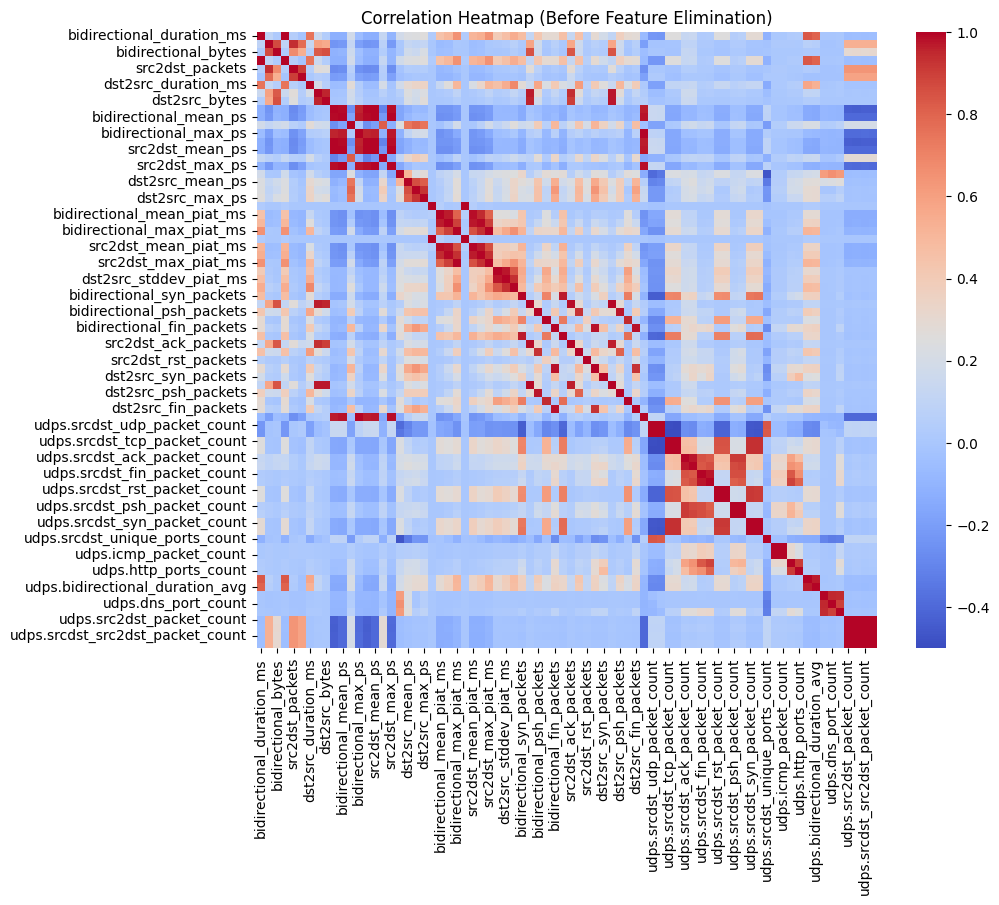

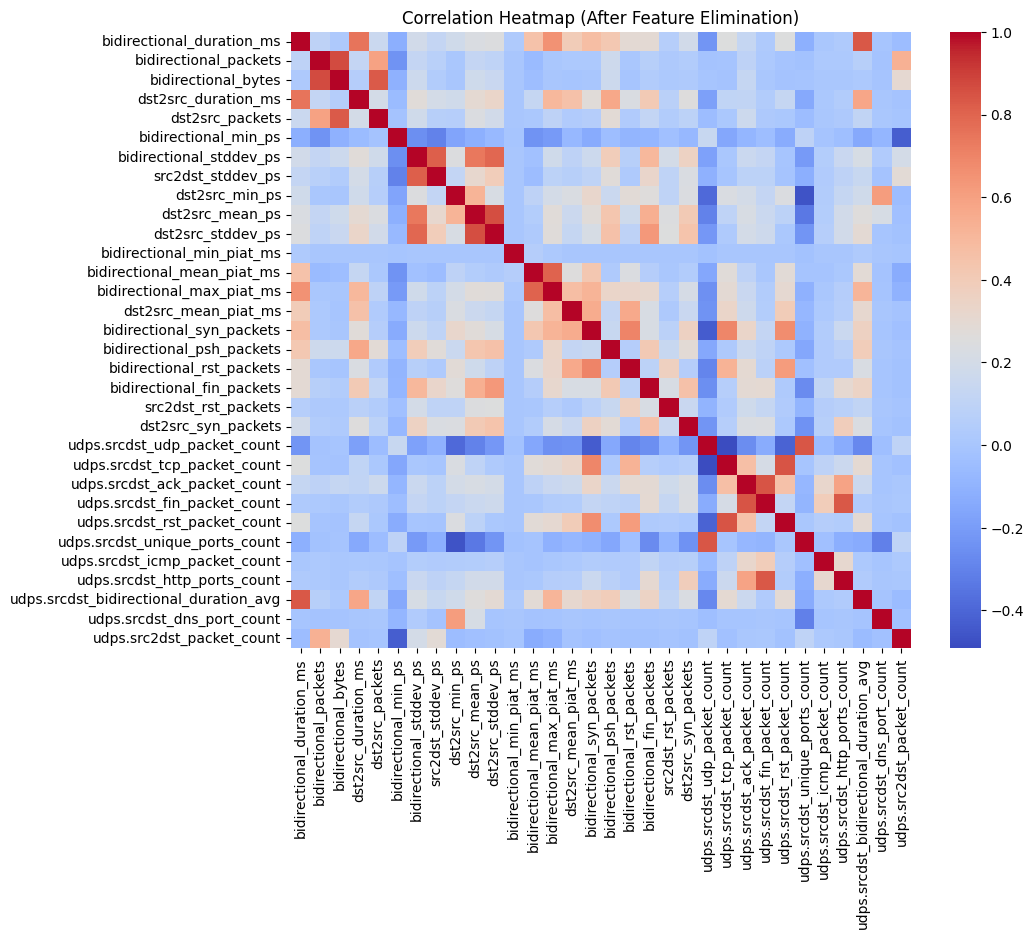

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(X_vt.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (Before Feature Elimination)")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(X_corr.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (After Feature Elimination)")
plt.show()

In [12]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif.sort_values(by="VIF", ascending=False)

vif_table = calculate_vif(X_corr)
print(vif_table.head(10))

                           feature           VIF
26  udps.srcdst_unique_ports_count  24123.422535
21    udps.srcdst_udp_packet_count  23919.108818
22    udps.srcdst_tcp_packet_count    252.772336
30      udps.srcdst_dns_port_count     58.119388
6          bidirectional_stddev_ps     33.620010
24    udps.srcdst_fin_packet_count     19.097538
2              bidirectional_bytes     17.078660
7                src2dst_stddev_ps     14.123014
9                  dst2src_mean_ps     12.640436
23    udps.srcdst_ack_packet_count     11.915281


In [13]:
def reduce_vif(X, threshold=10):
    while True:
        vif = calculate_vif(X)
        max_vif = vif["VIF"].max()
        
        if max_vif > threshold:
            drop_feature = vif.iloc[0]["feature"]
            print(f"Dropping {drop_feature} (VIF={max_vif:.2f})")
            X = X.drop(columns=[drop_feature])
        else:
            break
    return X

X_final = reduce_vif(X_corr)
print("Final number of features:", X_final.shape[1])

Dropping udps.srcdst_unique_ports_count (VIF=24123.42)
Dropping bidirectional_stddev_ps (VIF=33.62)
Dropping udps.srcdst_fin_packet_count (VIF=18.70)
Dropping bidirectional_bytes (VIF=14.97)
Dropping bidirectional_duration_ms (VIF=10.82)
Final number of features: 27


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
start_time = time.perf_counter()
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
end_time = time.perf_counter()
elapsed_time_pandas = end_time - start_time
elapsed_time_pandas

1533.5885639000007

In [22]:
start_time = time.perf_counter()
model = XGBClassifier(
    tree_method="hist",
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_lambda=1,
    reg_alpha=0.1,
    n_jobs=-1
)
model.fit(X_train, y_train)
end_time = time.perf_counter()
elapsed_time_pandas = end_time - start_time
elapsed_time_pandas

2592.8943977000017

In [23]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob, multi_class="ovr"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7846472661539627
ROC-AUC: 0.9831639005011221

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10655
           1       0.71      0.86      0.78    178752
           2       0.65      0.15      0.25     58000
           3       0.64      0.64      0.64     30000
           4       1.00      1.00      1.00    183522
           5       0.76      0.77      0.77     13000
           6       0.54      0.55      0.54     83000
           7       0.62      0.38      0.47     21330
           8       0.55      0.25      0.34     21000
           9       0.50      0.55      0.52     58000
          10       0.71      0.71      0.71     38000
          11       0.73      0.80      0.76     11011
          12       0.76      0.48      0.59      1122
          13       1.00      1.00      1.00      8401
          14       1.00      1.00      1.00    190059
          15       0.47      0.79      0.59     30000

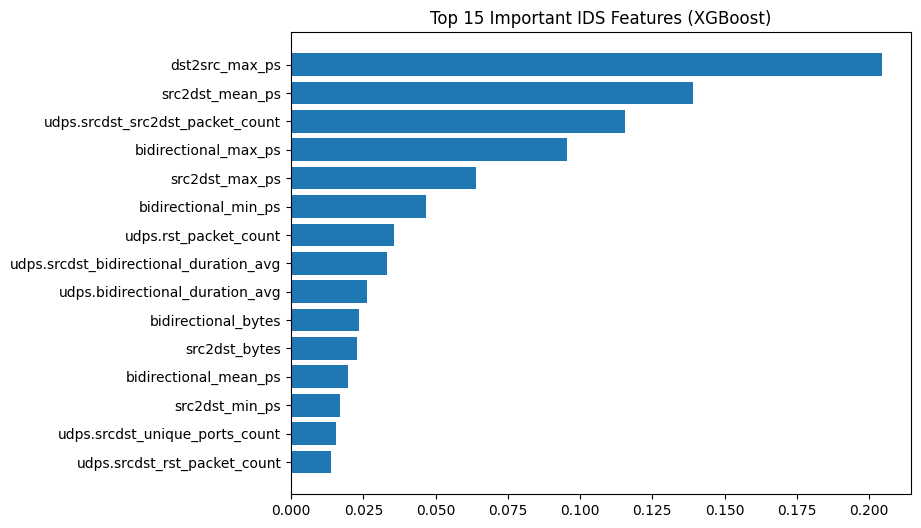

In [24]:
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 15 Important IDS Features (XGBoost)")
plt.show()